In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# create the environment
import janestreet
print('Creating competition environment...', end='')
env = janestreet.make_env()
print('Finished.')

Creating competition environment...Finished.


In [8]:
train = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv')

In [9]:
features = [col for col in list(train.columns) if 'feature' in col]

train = train[train['weight'] != 0]

train['action'] = (train['resp'].values > 0).astype(int)

f_mean = train.mean()
train.fillna(f_mean)

X = train.loc[:, features] # Features
y = train['action'].astype(int) # Target variable
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.3, random_state=55)


In [11]:
import plotly.express as px

#空值計算
features = [f"feature_{x}" for x in range(130)]
null_count = train[features].isna().sum().sort_values(ascending=True)
null_count = null_count[null_count >0]
fig = px.bar(y=null_count.index,x=null_count.values)
fig.show()


In [12]:
train.fillna(train.mean(),inplace=True)
print("Number of features with null values:",np.sum(train.isna().sum()>0))


Number of features with null values: 0


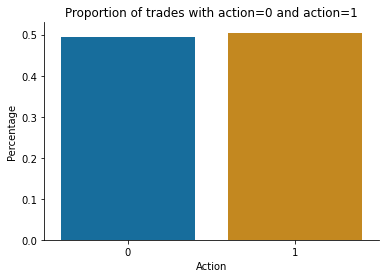

In [13]:
import seaborn as sns

# 檢查目標是否平衡
sns.set_palette("colorblind")
ax = sns.barplot(y_train.value_counts().index, y_train.value_counts()/len(y_train))
ax.set_title("Proportion of trades with action=0 and action=1")
ax.set_ylabel("Percentage")
ax.set_xlabel("Action")
sns.despine();


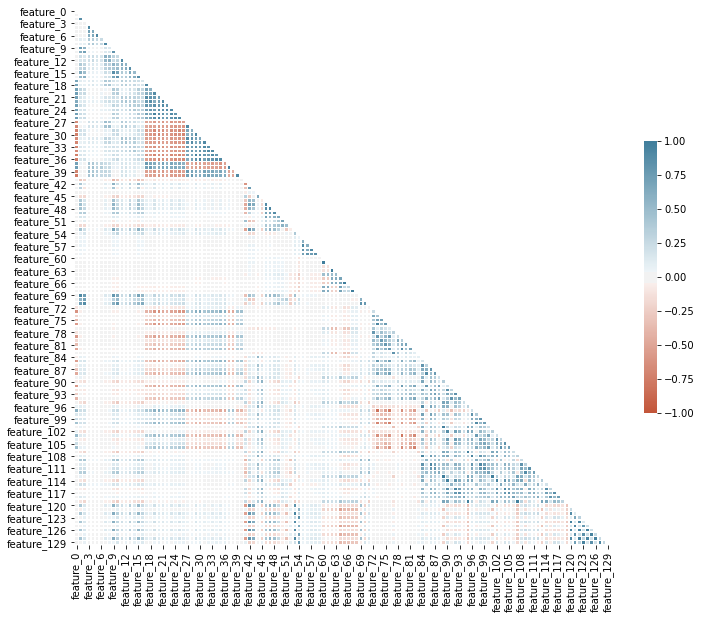

In [14]:
import matplotlib.pyplot as plt

# 製對角線相關熱圖，以查看特徵之間是否存在強相關性

# 計算相關矩陣
corr = X_train.corr()

# 對上面的三角產生遮罩
mask = np.triu(np.ones_like(corr, dtype=bool))

# matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# 遮罩熱力圖和長寬比
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 幾個特徵間有很強的相關性


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 在執行PCA之前，我們需要對特徵進行歸一化，以使其均值和單位方差為零
#scaler = StandardScaler()
#scaler.fit(X_train)
#train_x_norm = scaler.transform(X_train)

#pca = PCA()
#comp = pca.fit(train_x_norm)

# 繪製圖表以顯示129個特徵中解釋的如何隨主要成分的數量而變化
#plt.plot(np.cumsum(comp.explained_variance_ratio_))
#plt.grid()
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Explained Variance')
#sns.despine();

# 前15個主要成分解釋了大約80％的變化
# 前40個主要成分解釋了大約95％的變化


In [ ]:
del train

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(depth=6,
                         iterations=500,
                         l2_leaf_reg=1e-20,
                         leaf_estimation_iterations=10,
                         logging_level='Silent',
                         loss_function='Logloss',
                         random_seed= 42)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
rcount = 0
for (test_df, prediction_df) in env.iter_test():
    X_test = test_df.loc[:, features]
    y_preds = clf.predict(X_test)
    prediction_df.action = y_preds
    env.predict(prediction_df)
    rcount += len(test_df.index)